### **Montar Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Sessão e leitura dos dados**

In [4]:
# Instalando o PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=dc59da1eb25d9af9e3c090af751be88a80895b823bf64a3593e350dbb1f0f2d8
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [5]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [6]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/4. Alura - Formacao Data Scientist/Curso 5 - Apache Spark - PLN/imdb-reviews-pt-br.csv",
                       escape = '\"',
                       header = True,
                       inferSchema = True)

### **Explorando os dados**



In [7]:
# O tamanho dos dados
print(f"Numero de linhas: {dados.count()}")
print(f"Numero de colunas: {len(dados.columns)}")


Numero de linhas: 49459
Numero de colunas: 4


In [8]:
# campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [9]:
# Conteudo
dados.limit(20).show(truncate=True)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [10]:
# Filtrar negativos e positivos
print("Comentario Negativo:")
(dados
 .filter(dados.id == 190)
 .select("text_pt")
 .show(truncate=False)
)

print("Comentario Positivo:")
(dados
 .filter(dados.id == 12427)
 .select("text_pt")
 .show(truncate=False)
)

Comentario Negativo:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                     

In [11]:
# Contabilizar comentários por tipo
(dados
 .groupBy('sentiment')
 .count()
 .show()
)

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



### **Limpando e Processando os dados**

In [12]:
# Bibliotecas
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [13]:
# Monta lista com palavras
amostra = dados.select('text_pt').sample(fraction=0.1, seed=101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

# Monta WordCloud
wordcloud = WordCloud(collocations=False,
                      width=1000,
                      height=600,
                      background_color='white',
                      prefer_horizontal=1).generate(str(tudo))

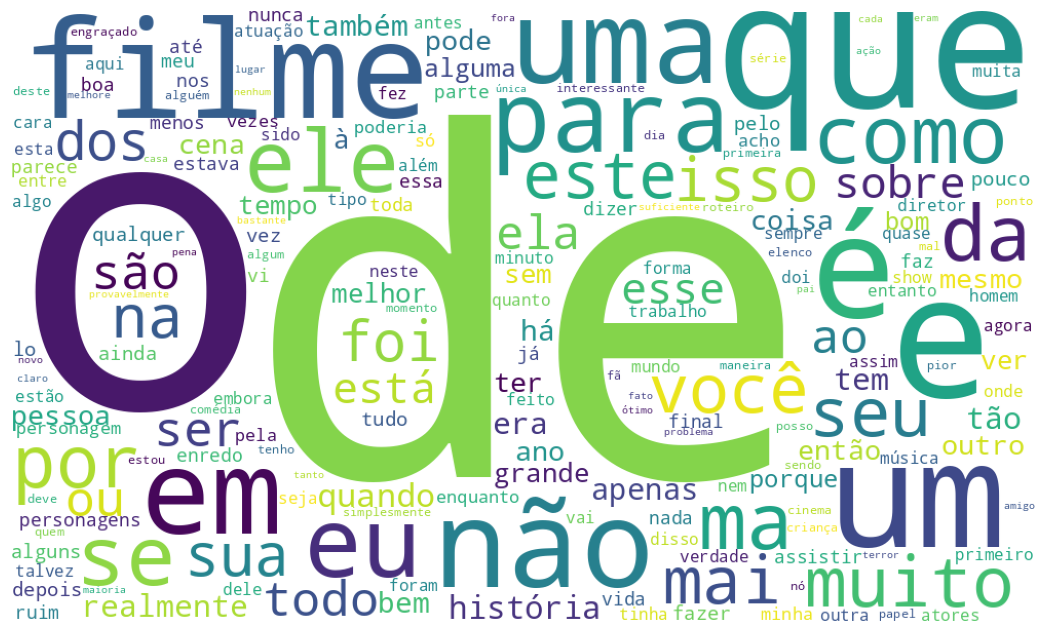

In [14]:
# Plot
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### **Limpeza**:  caracteres especiais

In [15]:
# Queremos retirar cestes tipos de caracteres
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# Exemplo de amostra
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [17]:
# importa functions
import pyspark.sql.functions as f

# Retira caracteres especiais
amostra = amostra.withColumn('texto_regex', f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))
amostra = amostra.withColumn('texto_espaco', f.trim(amostra.texto_regex))

In [18]:
# Show
amostra.show(truncate=False)

+------------------------------------------+-------------------------------+------------------------------+
|textos                                    |texto_regex                    |texto_espaco                  |
+------------------------------------------+-------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                      |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                 |
|"bora *_* "                               |bora                           |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |comprar: arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`

In [19]:
# Limpa dados
dados = dados.withColumn('text_en_regex', f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))
dados = dados.withColumn('text_en_clean', f.trim(dados.text_en_regex))


In [20]:
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
dados.columns

['id', 'text_en', 'text_pt', 'sentiment', 'text_en_regex', 'text_en_clean']

### **Tokenização**: Divisão em tokens

In [22]:
# importar tokenizador
from pyspark.ml.feature import Tokenizer

# Tokenizando os dados
tokenizer = Tokenizer(inputCol='text_en_clean', outputCol='tokens')
tokenizado = tokenizer.transform(dados)

(tokenizado
 .select("text_en_clean", "tokens")
 .limit(5)
 .show()
)

+--------------------+--------------------+
|       text_en_clean|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
+--------------------+--------------------+



In [23]:
tokenizado.columns

['id',
 'text_en',
 'text_pt',
 'sentiment',
 'text_en_regex',
 'text_en_clean',
 'tokens']

In [24]:
# importa biblioteca
from pyspark.sql.types import IntegerType

# Contar tokens por instância
contaTokens = f.udf(lambda tokens: len(tokens), IntegerType())

(tokenizado
 .select('text_en_clean', 'tokens')
 .withColumn("Freq_tokens", contaTokens(f.col("tokens")))
 .limit(5)
 .show()
)

+--------------------+--------------------+-----------+
|       text_en_clean|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
+--------------------+--------------------+-----------+



In [25]:
tokenizado.columns

['id',
 'text_en',
 'text_pt',
 'sentiment',
 'text_en_regex',
 'text_en_clean',
 'tokens']

### **Stop Words**: Remoção de palavras (conjunções, preposições etc.)

Exemplo:

In [26]:
# Exemplo
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
        (0, 'Spark MLlib não ajuda muito'),
        (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [27]:
# Exemplo expolrando biblioteca (nltk)
import nltk
nltk.download("stopwords")

# Prepara pacote
from nltk.corpus import stopwords
stop_A = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
stop_A[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [29]:
# Exemplo expolrando biblioteca (pyspark)
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("english")

In [30]:
stop_B[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

Dados:

In [31]:
# remover Stop Words dos dados com (pyspark)
remover = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords=stop_B)

# Remover Stop Words dos dados
tokenizado = remover.transform(tokenizado)

In [32]:
# Conta tokens
(tokenizado
 .select('tokens', 'texto_final')
 .withColumn("Freq_tokens", contaTokens(f.col("tokens")))
 .withColumn("Freq_tokens_limpos", contaTokens(f.col("texto_final")))
 .limit(5)
 .show()
)

+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[mr, costner, dra...|        168|                73|
|[this, is, an, ex...|[example, majorit...|        232|               131|
|[first, of, all, ...|[first, hate, mor...|        215|               111|
|[not, even, the, ...|[even, beatles, w...|        308|               169|
|[brass, pictures,...|[brass, pictures,...|        238|               140|
+--------------------+--------------------+-----------+------------------+



In [33]:
tokenizado.columns

['id',
 'text_en',
 'text_pt',
 'sentiment',
 'text_en_regex',
 'text_en_clean',
 'tokens',
 'texto_final']

### **Bag of Words**: Contagem de palavras

``[número de features, [cód. das palavras na ordem dos vocabulários], [frequência de cada palavra]]``

In [34]:
# CountVectorizer: Conta o numero de palavras em cada instância
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(tokenizado)
countVectorizer_features = model.transform(tokenizado)

In [35]:
(countVectorizer_features
 .select("texto_final", "CountVec")
 .limit(5)
 .show(truncate=True)
)

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(221187,[0,7,8,11...|
|[example, majorit...|(221187,[1,2,3,8,...|
|[first, hate, mor...|(221187,[0,2,4,11...|
|[even, beatles, w...|(221187,[0,1,2,4,...|
|[brass, pictures,...|(221187,[1,3,5,8,...|
+--------------------+--------------------+



In [36]:
model.vocabulary[:10]

['movie', 'film', 'one', '', 'like', 'good', 'even', 'time', 'really', 'see']

### **Hashing TF**:

In [37]:
# Hashing TF
# Hashinmg TF é uma opção alternativa para o countvector que limita a quantidade de palavras, no caso setamos em 50
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [38]:
(HTFfeaturizedData
 .select("texto_final", "hashingTF")
 .limit(5)
 .show()
)

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



### **TF-IDF**: Contabiliza e pondera as palavras

``[número de features, [cód. das palavras na ordem dos vocabulários], [peso ponderado de cada palavra]]``

In [39]:
# TF-IDF
from pyspark.ml.feature import IDF

idf = IDF(inputCol="hashingTF", outputCol="Features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [40]:
(TFIDFfeaturizedData
 .select("texto_final", "Features")
 .limit(5)
 .show(truncate=False)
)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Pipeline de transformações**

In [41]:
TFIDFfeaturizedData.columns

['id',
 'text_en',
 'text_pt',
 'sentiment',
 'text_en_regex',
 'text_en_clean',
 'tokens',
 'texto_final',
 'CountVec',
 'hashingTF',
 'Features']

In [42]:
# Relembrando os rótulos
(TFIDFfeaturizedData
 .groupBy('sentiment')
 .count()
 .show()
)

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [43]:
# Convertendo os rótulos para números
# 1. replace
# 2. stringIndexer (sentiment -> label)
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringIndexer.fit(dados).transform(dados)


In [44]:
# Quem é 0 e 1?
(dados
 .groupBy(["sentiment", "label"])
 .count()
 .show()
)

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [45]:
# Fazer o pipeline, unir todas as transformações
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol='text_en_clean', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='tokens_final')
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [46]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [47]:
(dados_transformados
 .limit(5)
 .show()
)

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_en_clean|label|              tokens|        tokens_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

### **Modelo de ML**

In [49]:
# Entendendo nossos dados
featureDF = dados_transformados.select(["features", "label"])

In [51]:
# Show dados tratados
(featureDF
 .limit(5)
 .show(truncate=True)
)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+



In [53]:
# Tipo da coluna
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [54]:
# Pipeline de transformação e ajuste
# Fazer o pipeline, unir todas as transformações
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol='text_en_clean', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='tokens_final')
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dtree = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dtree])

### **Amostra e Treino**

In [55]:
# Separando os dados
train, test = dados.randomSplit([0.7, 0.3], seed=101)

In [56]:
# Ajustando o modelo com a pipeline
dtree_model = pipeline.fit(train)

In [57]:
# Aplicando na base de teste
predictions = dtree_model.transform(test)

In [58]:
(predictions
 .limit(10)
 .show()
)

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_en_clean|label|              tokens|        tokens_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [369.0,1108.0]|[0.24983073798239...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

### **Teste e Métricas**

In [59]:
(predictions
 .select("label", "prediction")
 .show()
)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [60]:
# Acurácia
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acuracia = acc_evaluator.evaluate(predictions)

In [62]:
print(f"Acurácia = {acuracia}")

Acurácia = 0.6724696356275304


### **Nova Frase**

In [66]:
# Cria nova base
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "text_en_clean"])

In [67]:
# Aplica o pipeline completo às novas instâncias
nova_class = dtree_model.transform(nova_base)

In [68]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|       text_en_clean|              tokens|        tokens_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|   [32.0,7.0]|[0.82051282051282...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[173.0,839.0]|[0.17094861660079...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

